# PE2 - Concentrations d'alcool dans les spiritueux de la Société des alcools du Québec
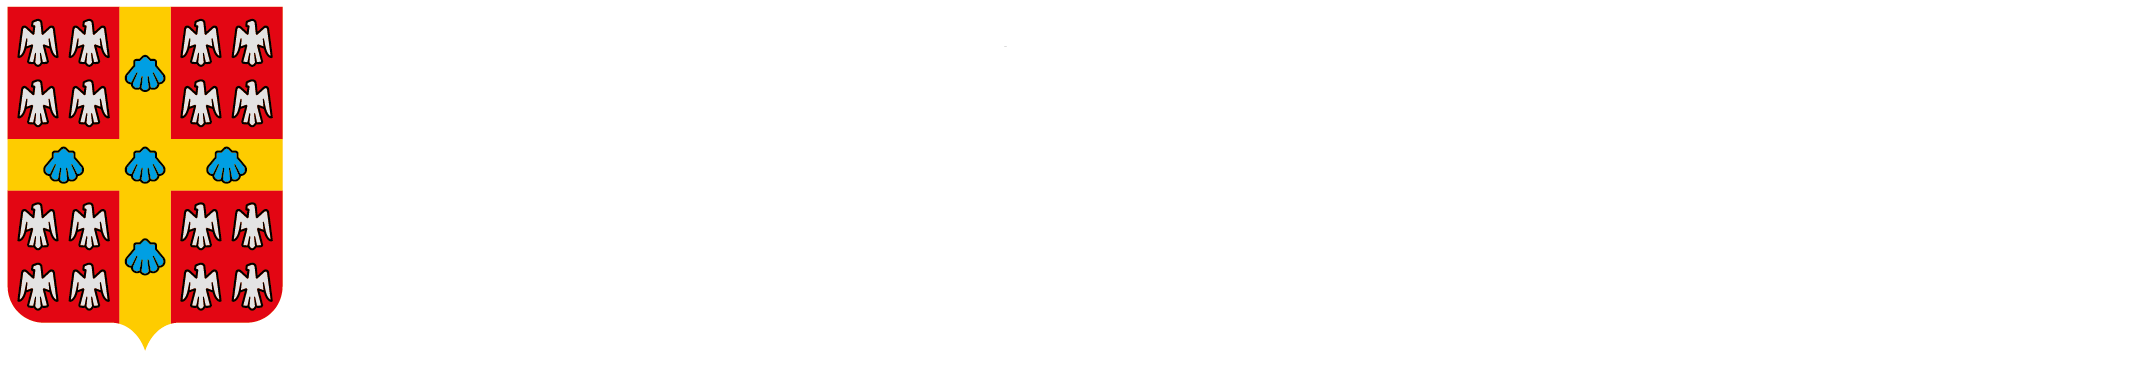
<font size="6"><center>PHY-2006: Optique expérimentale</center></font>
***
*Date:* 26 avril 2023<br>
*Remis à:* Daniel C. Côté et Mireille Quémener
***
Par:
- Gabriel Duquet (536 856 150)
- Gérémy Michaud (536 882 418)

## Préliminaires
Cette section sert à <ins>importer</ins> les modules nécessaires et à <ins>créer des fonctions</ins> utiles pour l'entièté du PE.

In [25]:
# !pip install --upgrade pip
# !pip install jupyter
# !pip install numpy
# !pip install scipy
# !pip install seaborn
# !pip install opencv-python

In [26]:
# -*- coding: utf-8 -*-

# La librairie numpy contient la majorité des éléments mathématiques utilisés dans ce travail.
import numpy as np
# La librairie matplotlib permet de générer des graphiques rapidement.
import matplotlib.pyplot as plt
# Le module pandas fournit des structures de données et des outils d'analyse de données hautes performances.
import pandas as pd
# Le module curve_fit utilise les moindres carrés non linéaires pour ajuster une fonction avec les données.
from scipy.optimize import curve_fit
# Le module r2_score détermine le score de régression du coefficient de détermination.
from sklearn.metrics import r2_score
# Le module find_peaks trouve des pics à l'intérieur d'un signal en fonction des propriétés des pics.
from scipy.signal import find_peaks
# Le module interp1d interpole une fonction 1-D.
from scipy.interpolate import interp1d

## Classes d'étalonnage et de traitement des données

### Classe Calibration
En périphérie de la classe, nous définissons des fonctions de conversion qui seront utilisés à l'intérieur de la classe. 

In [27]:
def nm2raman(x):
    """Fonction pour passer des nanomètres aux données de shift Raman.

    Args:
        x (any): Variables à convertir.

    Returns:
        function: Équation de nm à raman shift.
    """
    return 1 / 632.8e-7 - 1 / (x * 1e-7)

def raman2nm(x):
    """Fonction pour passer des données de shift Raman aux nanomètres.

    Args:
        x (any): Variables à convertir.

    Returns:
        function: Équation de raman shift à nm.
    """
    return 632.8 / (1 - 632.8 * x * 1e-7)

In [28]:
class Calibration:
    """Classe d'étalonnage où nous utilisons les échantillons étalons (éthanol et eau).

    Returns:
        classmethod: graphique_combine_ethanolage
    """
    # Initiliasation du dictionnaire des valeurs de concentration, de hauteur du pic, de position du pic et d'écart-type.
    # En dehors du constructeur pour la déclarer comme une variable de classe.
    ethanol = {}
    
    def __init__(self, fichier, nom, zero=False, conc=0, d=7, coupe = [1, -1], max_c=290, divismin = 1, max_p=290, pente = False,
        domaine_pic = [1050, 1100], eau=True, graph=False, rawdog = False, balance=1):
        """Initialisation de la classe.

        Args:
            fichier (string):Nnom du fichier où aller chercher les données.
            nom (string): Nom donné à l'échantillon.
            zero (bool, optional): Si le fichier est celui du spectre de l'eau, mettre True. Defaults to False.
            conc (int, optional): La concentration de l'échantillon. Defaults to 0.
            d (int, optional): À chaque d points, un point est interpoler (ex.[::d]). Defaults to 7.
            coupe (list, optional): Découpage du graphique sur une région d'intéret. Defaults to [1, -1].
            max_c (int, optional): La concavité max pour le choix des points de l'interpolation (voir enlever_bruit). Defaults to 290.
            divismin (int, optional): Paramètre qui divise la concavité minimum pour plus de présision dans la sélection de donné. Defaults to 1.
            max_p (int, optional): Pente max pour le choix des points de l'interpolation (voir enlever_bruit). Defaults to 290.
            pente (bool, optional): Prendre en compte la pente en plus de la concavité. Defaults to False.
            domaine_pic (list, optional): Indique l'intervale dans lequel se situe le pic étudié. Defaults to [1050, 1100].
            eau (bool, optional): Soustraire le spectre de l'eau. Defaults to True.
            graph (bool, optional): Voir les graphiques qui suivent chaque étape de l'analyse pour comprendre ce qui se passe. Defaults to False.
            rawdog (bool, optional): Afficher le graphique du spectre sans aucune modification. Defaults to False.
            balance (int, optional): Facteur qui blance les données si elle n'ont pas tous le même temps d'acquisition.. Defaults to 1.
        """
        # Données de calibration en fonction des pic de la lampe au Mercure
        self.calibration_Hg = {206:709.186, 221:708.19, 473:690.753, 730:671.643}
        # Initialisation du spectre de l'eau
        self.y_0 = []
        # Initialisation des variables
        self.__dict__.update({
            "nom": nom,
            "d": d,
            "max_p": max_p,
            "pente": pente,
            "max_c": max_c,
            "domaine_pic": domaine_pic,
            "conc": conc,
            "balance": balance,
            "zero": zero,
            "divismin": divismin
        })
        # Calculer les coefficients de la régression polynomiale de degré n=1
        slope, intercept =np.polyfit(list(self.calibration_Hg.keys()), list(self.calibration_Hg.values()), deg=1)
        # Ajuster l'axe des x (1340 pixels) selon la calibration
        x_new = np.array(range(1339))
        nm = x_new * slope + intercept
        # Transformer les x en cm-1.
        self.raw_x_nm = np.array(nm[::-1])
        self.raw_x = nm2raman(np.array(nm[::-1]))  
        # Extraire le fichier puis isoler les valeurs d'intensité
        file = pd.read_csv(fichier)
        intensity_data = file.iloc[:,2]
        # Définir des paramètre pour découper les données sur la région d'intéret sans chier les intervales de self.d
        cutcut = coupe[0]+d
        cutcut2 = coupe[1]-d
        
        self.cut = cutcut 
        self.cut2 = int(np.floor(cutcut2 / d) * d) - len(intensity_data) + cutcut + int(np.floor((len(intensity_data) - cutcut) / d) * d)
        
        #Découpe les données sur la région d'intéret
        self.raw_y = np.array(intensity_data)/balance
        self.x_raman = self.raw_x[self.cut:self.cut2][::-1]
        
        # Enlève le spectre de l'eau si voulu.
        if eau:
            self.enlever_zero()
        else:
            self.y_corrige_eau = self.raw_y
        
        # Affiche le spectre sans modification si voulu.
        if rawdog:
            plt.plot(self.raw_x[self.cut - self.d:self.cut2+self.d][::-1], self.y_corrige_eau[-self.cut2-self.d:self.d - self.cut])
            plt.xlabel("Décalage Raman [cm"'$^{-1}$'"]", fontsize= 12)
            plt.ylabel("Intensité [-]", fontsize= 12)
            plt.xticks(fontsize= 12)
            plt.yticks(fontsize= 12)
            plt.show()
        
        if zero: self.ethanol[self.nom] = [0, 0, 0, 50, 0, 0, [0, 1]] 
        else:
            #soustrait la fluorescence.
            self.enlever_bruit(max_c=max_c, max_p=max_p, divismin = divismin)
            # Trouve les pics.
            self.peaks_raman, _ = find_peaks(self.y_corrige_bruit,
                                        prominence=180)  # Si les X sur les peaks apparaissent pas, bagosser avec la valeur de prominence
            #trouve le pic maximum dans l'intérvale donné par domaine_pic et stock tout les infos dans le dictionnaire d'étalonage
            self.pic_max()
            
            #affichage des graphiques aidant à la compréhension et à la sélection des bons paramètres max_c, p et divismin 
            if graph:
                self.graphique_selection()
                self.graphique_corrige()

    def enlever_zero(self):
        """
        Méthode qui soustrait le spectre de l'eau (le fichier dénoté zero = True) aux données.
        :return: np.array, Le spectre corrigé après le retrait de l'eau.
        """
        if self.zero:
            self.y_0 = self.raw_y
            self.y_corrige_eau = self.raw_y
        elif len(self.y_0) == 0:
            self.y_corrige_eau = self.raw_y
        else:
            self.y_corrige_eau = self.raw_y - self.y_0
        return self.y_corrige_eau

    def enlever_bruit(self, max_c=290, divismin = 1, max_p=290):
        """
        La méthode qui permet d'enlever le bruit provenant de fluorescence ou autre. Fait une courbe d'interpolation
        linéaire en prenant bien soin de ne pas prendre les points qui sont dans des pics. Les points à garder sont ceux
        qui possèdent une concavité et une pente inférieures à la valeur absolue de max_c.
        :param max_c: float ou int, concavité maximale des points d'interpolation. Définitivement pas le même
                    pour toutes les situations, donc il va falloir gosser avec.
        :param divismin: float ou int, paramètre qui divise la concavité minimum pour plus de présision si besoin. À ajuster au cas par cas
        :param p: float ou int, pente maximale pour le choix des points de l'interpolation. Là aussi c'est du cas par cas
        :param graph: True si tu veux voir le graphique avec les concavités de chaque point.
        :return: self.y_corrige_bruit, liste des valeur y après la soustraction de la fluorescence
        """
        #Découpe les données sur la région d'intéret
        x_interp = self.raw_x_nm[self.cut-self.d:self.cut2+self.d][::-1]
        y_interp = self.y_corrige_eau[-self.d-self.cut2:self.d-self.cut]
        
        # liste initiale des indices avec lesquels on interpole.
        liste_indices = list(np.array(range(len(x_interp))))
        crop = liste_indices[::self.d]
        
        self.bons_x = []
        self.bons_y = []
        self.liste_c = []
        self.liste_p = []
        self.bons_y_ind = []
        
        for i, j in enumerate(crop):
            if i in [0, 1, len(crop) - 2, len(crop) - 1]:
                # S'assure de prendre les premiers et derniers points.
                c = 0
                p = 0
            else:
                # calcule la concavité, désignée par a
                x_1 = x_interp[crop[i - 1]]
                x_2 = x_interp[crop[i]]
                x_3 = x_interp[crop[i + 1]]
                y_1 = y_interp[crop[i - 1]]
                y_2 = y_interp[crop[i]]
                y_3 = y_interp[crop[i + 1]]
                c = int(np.floor(((y_1 - y_2) * (x_2 - x_3) + (y_3 - y_2) * (x_1 - x_2)) / (
                        (x_1 ** 2 - x_2 ** 2) * (x_2 - x_3) + (x_3 ** 2 - x_2 ** 2) * (x_1 - x_2))))
                # calcule la pente, désignée par c
                p = int(np.floor((y_1 - y_3) / (x_1 - x_3)))
            self.liste_c.append(c)
            self.liste_p.append(p)
            
            # Vérifie si a et b respectent les conditions établie par self.max_c pour la concavité et self.p pour la pente.
            if -max_c/divismin < c < max_c and (-max_p < p < max_p or not self.pente) :
                
                if i != len(crop):#fait une liste avec les indices des points sélectionné pour le cacule de l'incertitude
                    self.bons_y_ind += list(np.array(range(self.d))+j)
                
                #stockage des points sélectionnés
                self.bons_y.append(y_interp[j])
                self.bons_x.append(x_interp[j])
        
        # Courbe d'interpolation
        self.f2 = interp1d(self.bons_x, self.bons_y, kind='linear')
        
        # Soustraction des données expérimentales par la courbe d'interpolation pour enlever la fluorescence
        self.y_corrige_bruit = self.y_corrige_eau[-self.cut2:-self.cut] - self.f2(raman2nm(self.x_raman))
        
        return self.y_corrige_bruit

    def pic_max(self):
        """"
        Trouve la hauteur du pic dans la plage donnée et sa position. Crée une entrée de dictionnaire de concentration
        avec comme clé le nom spécifié lors de l'initialisation. Cette entrée est une liste contenant la concentration,
        la hauteur du pic, sa position,  l'incertitude, les données en x, les données en y et l'intervale de recherche pour le pic max .

        Returns:
            list: La position et la hauteur du pic maxima
        """
        where_peaks_raman = self.x_raman[self.peaks_raman][::-1]
        ind_pic = []
        
        pic_central = [idx for idx, element in enumerate(where_peaks_raman) if self.domaine_pic[0] < element < self.domaine_pic[1]]
        for i in where_peaks_raman[pic_central]:
            ind_pic.append(list(self.x_raman).index(i))
        self.peakmax = max(self.y_corrige_bruit[ind_pic])
        self.ind_max = list(self.y_corrige_bruit).index(self.peakmax)
        self.x_max = self.x_raman[self.ind_max]
        
        # liste du bruit restant après la soustraction de la fluorescence
        self.valeurbruit = self.y_corrige_bruit[list(np.array(self.bons_y_ind[1+self.d:-1-self.d])-1-self.d)]
        # calcule de l'incertitude par l'écart type
        ecart = 3*np.std(self.valeurbruit)
        self.ethanol[self.nom] = list(np.array([self.conc, self.peakmax, self.x_max, ecart, self.x_raman, self.y_corrige_bruit, np.array(self.domaine_pic)*self.balance], dtype=object)/self.balance)
        return [self.x_max, self.peakmax]

    def graphique_selection(self):
        """
        La méthode qui permet d'afficher un graphique lors de la selection de points avec les points sélectionnés pour l'interpolation de la fluorescence.
        Au dessus de chaque point est afficher la concavité et la pente du point.
        """
        #Découpe les données sur la région d'intéret
        x_interp = self.raw_x_nm[self.cut - self.d:self.d+self.cut2][::-1]
        y_interp = self.y_corrige_eau[-self.d-self.cut2:self.d - self.cut]
        
        
        plt.figure(figsize=(10, 6), dpi=100)
        
        #trace le spectre initiale en rouge et l'interpolation sur la fluorescence en vert
        plt.plot(self.x_raman, self.f2(raman2nm(self.x_raman)), c = 'green', label="Courbe d'interpolation")
        plt.plot(self.x_raman, self.y_corrige_eau[-self.cut2:-self.cut], c = 'red', label=f"Spectre de {self.nom}",
                linewidth=0.5)
        
        #Affiche les points utilisés lors de la selection de point.
        plt.scatter(nm2raman(x_interp[::self.d]), y_interp[::self.d], marker='^', s=10, label="Points par défaut")
        
        #Affiche la concavité et la pente au dessus de chaque point.
        for x, y, r, p in zip(nm2raman(x_interp[::self.d]), y_interp[::self.d], self.liste_c, self.liste_p):
            concavite = f"{r}"
            pente = f"{p}"
            plt.annotate('c:'+concavite,  # this is the text
                        (x, y),  # these are the coordinates to position the label
                        textcoords="offset points",  # how to position the text
                        xytext=(0, 10),  # distance from text to points (x,y)
                        ha='center')
            plt.annotate('b:'+pente,  # this is the text
                        (x, y),  # these are the coordinates to position the label
                        textcoords="offset points",  # how to position the text
                        xytext=(0, 20),  # distance from text to points (x,y)
                        ha='center')
        
        #Affiche les points qui on été sélectionné comme ne faisant pas partie d'un pic. AKA les points qui servent à interpolé  la fluorescence.
        plt.scatter(nm2raman(np.array(self.bons_x)), self.bons_y, marker='s', s=10, label="Points corrigés")
        
        #trace des X sur les pics (ca suce moi je le mets en commentaire)
        plt.plot(self.x_raman[self.peaks_raman], self.y_corrige_eau[-self.cut2:-self.cut][self.peaks_raman], "x", label=f"Pics")
        
        plt.xlabel("Décalage Raman [cm"'$^{-1}$'"]", fontsize= 15)
        plt.ylabel("Intensité [-]", fontsize= 15)
        plt.xticks(fontsize= 15)
        plt.yticks(fontsize= 15)
        plt.tick_params(direction='in')
        plt.legend(loc="upper right", fontsize= 15)
        
        #Ajustement de l'affichage, peut être changé si besoin
        xmin, xmax = plt.xlim()
        plt.xlim(xmin+30, xmax-30)
        ymin, ymax = plt.ylim()
        plt.ylim(ymin+20, ymax-20)
        
        plt.show()

    def graphique_corrige(self):
        """
        La méthode qui permet d'afficher un graphique de l'intensité après la soustraction de la fluorescence. Donc un graphique des pics isolés.
        """
        # Graphique après la correction.
        plt.figure(figsize=(10, 6), dpi=100)
        
        # trace les pics après la correction
        plt.plot(self.x_raman, self.y_corrige_bruit, label=f"Spectre traité de {self.nom}")
        
        # pose un point sur le sommet du pic considéré dans l'intervale
        plt.plot(self.x_max, self.peakmax, "o", label=f"Maximum entre {self.domaine_pic[0]} et {self.domaine_pic[1]}")
        
        plt.xlabel("Décalage Raman [cm"'$^{-1}$'"]", fontsize= 15)
        plt.ylabel("Intensité [-]", fontsize= 15)
        plt.xticks(fontsize= 15)
        plt.yticks(fontsize= 15)
        plt.tick_params(direction='in')
        plt.legend(loc="upper right", fontsize= 15)
        
        #Ajustement de l'affichage, peut être changé si besoin
        xmin, xmax = plt.xlim()
        plt.xlim(xmin+30, xmax-30)
        ymin, ymax = plt.ylim()
        plt.ylim(ymin+10, ymax-10)
        
        plt.show()
        
    @classmethod # La méthode d'instance est appelée directement avec la classe comme premier argument.
    def graphique_combine_ethanolage(cls):
        """
        Fouille dans dictionaire de l'étalonge pour faire un beau graphique de comparaison pour le rapport de lab.
        """
        i =0
        colors = ["gainsboro","lightgrey", "silver", "darkgrey", "slategrey", "grey", "dimgrey" , "black", "blue"][::-1] 
        concentrations = [7, 10, 23, 35, 48, 54, 62, 69, 0][::-1]  # hardcoder
        plt.figure(figsize=(10, 6), dpi = 100)
        plt.rcParams.update({"font.size":15})
        for couple in cls.ethanol.values():
            if i ==0 :
                i+=1
            else:
                plt.plot(couple[4], couple[5], c=colors[i], label=f"[{concentrations[i]} % m/V]") 
                i += 1
        plt.legend(fontsize=18)
        plt.tick_params(direction="in")
        plt.xlim(800, 1750)
        plt.ylim(-1500, 19000)
        # Mettre les pics d'éthanol
        plt.axvline(1450, c="red")  # hardcode
        plt.axvline(1063, c="red")
        plt.axvline(1125, c="red")
        plt.axvline(850, c="red")
        plt.xticks(position=(0.01,-0.01))
        plt.xlabel("Décalage Raman [cm$^{-1}$]")
        plt.ylabel("Intensité [-]")

        plt.twiny()
        plt.xticks([850, 1063, 1125, 1450], fontsize=18)
        plt.xlim(800, 1750)
        plt.tick_params(direction="in")

        plt.show()

### Classe Samples
Permet de prendre en compte l'échantillonage

In [29]:
def linear_eq(x, slope, intercept):
    """Décrit l'équation d'une droite de régression linéaire.

    Args:
        x (any): Valeurs prises en compte dans la route
        slope (any): Pente de la droite
        intercept (any): Zéro de la droite

    Returns:
        function: Fonction de la droite de régression linéaire
    #"""
    return slope * x + intercept

In [30]:
class Samples(Calibration):
    """
    Classe pour l'échantillonage. À mettre dans cette classe les échantillons à analyser.
    Méthodes:
    enlever_zero:
    enlever_bruit
    """
    echantillons = {}

    def __init__(self, fichier, nom, d=7, coupe = 0, zero=False, max_p=290, max_c=290, domaine_pic = [1050, 1100], divismin = 1, pente = False, eau=True, graph=False, rawdog = False, balance=1):
        super().__init__(fichier, nom, d=d, coupe = coupe, zero=zero, max_p=max_p, max_c=max_c, domaine_pic = domaine_pic, divismin = divismin, pente = pente, eau=eau, graph=graph, rawdog = rawdog, balance=balance)

    def pic_max(self):
        """
        Trouve la hauteur du pic dans la plage donnée et sa position. Crée une entrée de dictionnaire de concentration
        avec comme clé le nom spécifié lors de l'initialisation. Cette entrée est une liste contenant la concentration,
        la hauteur du pic, sa position,  l'incertitude, les données en x, les données en y et l'intervale de recherche pour le pic max .

        :return: list(self.x_max, self.peakmax): La position et la hauteur du pic maximal
        """
        where_peaks_raman = self.x_raman[self.peaks_raman][::-1]
        ind_pic = []
        pic_central = [idx for idx, element in enumerate(where_peaks_raman) if self.domaine_pic[0] < element < self.domaine_pic[1]]
        
        for i in where_peaks_raman[pic_central]:
            ind_pic.append(list(self.x_raman).index(i))
        self.peakmax = max(self.y_corrige_bruit[ind_pic])
        self.ind_max = list(self.y_corrige_bruit).index(self.peakmax)
        self.raw_peakmax = self.y_corrige_eau[self.ind_max]
        self.x_max = self.x_raman[self.ind_max]
        
        #liste du bruit restant après la soustraction de la fluorescence
        self.valeurbruit = self.y_corrige_bruit[list(np.array(self.bons_y_ind[1+self.d:-1-self.d])-1-self.d)]
        
        # calcule l'incertitude à partir de l'écart type possibilité de multiplié l'écart par 3 aulieu de 1 pour de plus grande incertitude
        ecart = 1*np.std(self.valeurbruit)
        Samples.echantillons[self.nom] = [self.conc, self.peakmax, self.x_max, ecart, self.x_raman, self.y_corrige_bruit, self.domaine_pic]
        return [self.x_max, self.peakmax]

    def concentration(self):
        """
        Trouve la concentration d'une seule solution à l'aide des échantillons fournis pour l'étalonnage.
        :return: list, la concentration de la substance dans une liste, parce que pourquoi pas.
        """
        liste_x = []
        liste_y = []
        liste_emplacement = []
        liste_erreur = []
        domaine_pic = ['mauvaise calibration dans fonction analyse', 'fuck you regle le problème']
        # On trace les points de données (concentration, hauteur du pic)
        # couple dénote simplement les données du dictionnaire "ethanol", soit [conc, hauteur_pic, pos_pic, incert, donné en x, donné en y, intervale pour le pic]
        for couple in super().ethanol.values():
            print(couple)
            if couple[1] == 0:
                liste_x.append(0)
                liste_erreur.append(0)
            else:
                liste_x.append(couple[0])
                liste_emplacement.append(couple[2])
                liste_erreur.append(couple[3])
                domaine_pic = couple[6]
            liste_y.append(couple[1])

        liste_y = np.array(liste_y)
        liste_x = np.array(liste_x)
        
        # On se fait une énorme droite de régression.
        popt, pcov = curve_fit(linear_eq, liste_y, liste_x)
        A, B = popt
        #calcule du R^2 
        y_pred = linear_eq(liste_y, *popt)
        print(f"Valeur du r^2 pour la droite: {r2_score(liste_x, y_pred)}")
        
        # Droite de régression min
        popt, pcov = curve_fit(linear_eq, liste_y+liste_erreur, liste_x)
        A1, B1 = popt
        
        # Droite de régression min
        popt, pcov = curve_fit(linear_eq, liste_y-liste_erreur, liste_x)
        A2, B2 = popt
        
        #paramètre de la droite avec incertitude'$%s$' %r'5e^{-x} + x - 5'
        print(f"({A:.6f} ± {np.abs((A1-A2)/2):.6f})x + ({B:.2f} ± {np.abs((B1-B2)/2):.2f})")
        
        # On fait un énorme graphique
        plt.figure(figsize=(10, 6), dpi=100)
        plt.plot(liste_y, liste_x, "o", label="Points d'étalonnage")
        # plt.plot(liste_y, droite(liste_y, A, B), label="Droite de régression")
        
        etiquette = f"Intensité du pic maximum entre {domaine_pic[0]} et {domaine_pic[1]} de décalage Raman [-]"
        # etiquette = f"Intensité du pic maximum à 1063 de décalage Raman [-]"
        # etiquette = f"Intensité du pic maximum à 850 de décalage Raman [-]"
        plt.xlabel(etiquette)
        plt.ylabel("Concentration en sucre [%]")
        plt.show()
        
        # plt.plot(liste_y, liste_x, "o", label="Points d'étalonnage")
        plt.errorbar(liste_y, liste_x, xerr=liste_erreur, fmt='.', label="Points d'étalonnage")
        plt.plot(liste_y, linear_eq(liste_y, A, B), label="Droite de régression")
        liste_conc = []
        couple = Samples.echantillons[self.nom]
        liste_conc.append(linear_eq(couple[1], A, B))
        erreur = np.abs(0.5 * linear_eq(couple[1] + couple[3], A, B) - 0.5 * linear_eq(couple[1] - couple[3], A, B))
        plt.plot(couple[1], linear_eq(couple[1], A, B), ".", label=f"Concentration de {self.nom}")
        plt.errorbar(couple[1], linear_eq(couple[1], A, B), xerr=couple[3], yerr=erreur)
        print(f"\n snr {self.nom}: {couple[1] / couple[3]:.2f} \n Concentration {self.nom}: {linear_eq(couple[1], A, B):.2f} ± {erreur:.2f}")
        liste_emplacement.append(couple[2])
        etiquette = f"Intensité du pic maximum entre {self.domaine_pic[0]} et {self.domaine_pic[1]} de décalage Raman [-]"
        # etiquette = f"Intensité du pic maximum à 1063 de décalage Raman [-]"
        # etiquette = f"Intensité du pic maximum à 850 de décalage Raman [-]"
        plt.xlabel(etiquette)
        plt.ylabel("Concentration en sucre [%]")
        plt.legend()
        plt.show()
        return liste_conc

    @classmethod
    def analyse(cls):
        """
        Trouve la concentration de chaque échantillon à l'aide des échantillons d'étalonnage. Fonctionne essentiellement
        comme self.concentration, mais pour tous les échantillons en même temps.
        :return: dict, {nom: concentration}
        """
        liste_x = []
        liste_y = []
        liste_emplacement = []
        liste_erreur = []
        domaine_pic = ['mauvaise calibration dans fonction analyse', 'fuck you regle le problème']
        # On trace les points de données (concentration, hauteur du pic)
        
        for couple in super().ethanol.values(): 
            if couple[1] == 0:
                liste_x.append(0)
                liste_erreur.append(200)
            else:
                liste_x.append(couple[0])
                liste_emplacement.append(couple[2])
                liste_erreur.append(couple[3])
                domaine_pic = couple[6]
            liste_y.append(couple[1])
        liste_y = np.array(liste_y)
        liste_x = np.array(liste_x)
        
        # On se fait une énorme droite de régression.
        popt, pcov = curve_fit(linear_eq, liste_y, liste_x)
        A, B = popt
        #calcule du R^2 
        y_pred = linear_eq(liste_y, *popt)
        print(f"Valeur du r^2 pour la droite: {r2_score(liste_x, y_pred)}")
        
        # Droite de régression min
        popt, pcov = curve_fit(linear_eq, liste_y+liste_erreur, liste_x)
        A1, B1 = popt
        
        # Droite de régression min
        popt, pcov = curve_fit(linear_eq, liste_y-liste_erreur, liste_x)
        A2, B2 = popt
        
        #paramètre de la droite avec incertitude'$%s$' %r'5e^{-x} + x - 5'
        print(f"({A:.6f} ± {np.abs((A1-A2)/2):.6f})x + ({B:.2f} ± {np.abs((B1-B2)/2):.2f})")
        
        #print(f"erreur = {liste_erreur}")
        
        # On fait un énorme graphique
        plt.figure(figsize=(10, 6), dpi=100)
        
        # affichage d'un intervale de confiance sur la droite de régression à l'aide des droites min max.
        plt.fill_between(x = liste_y[[0, -1]], y1 = linear_eq(liste_y[[0, -1]], A2, B2), y2 = linear_eq(liste_y[[0, -1]], A1, B1),interpolate = True, color='gray', alpha=0.5, linewidth=0.01, label='Intervalle de confiance')
        
        plt.plot(liste_y, linear_eq(liste_y, A, B), label="Droite de régression", c = 'red', ls ='--', lw = 1)
        plt.scatter(liste_y, liste_x,s = 12, alpha = 1, c='blue', label="Points d'étalonnage")
        
        etiquette = f"Intensité du pic maximum entre {domaine_pic[0]} et {domaine_pic[1]} de décalage Raman [-]"
        #etiquette = "Intensité du pic maximum autour de 1063 cm"'$^{-1}$'" de décalage Raman [-]"
        #etiquette = "Intensité du pic maximum autour de 850 cm$^{-1}$ de décalage Raman [-]"
        
        plt.xlabel(etiquette, fontsize= 15)
        plt.ylabel("Concentration en sucre [%m\V]", fontsize= 15)
        plt.xticks(fontsize= 15)
        plt.yticks(fontsize= 15)
        plt.tick_params(direction='in')
        plt.legend(fontsize= 15)
        
        #Ajustement de l'affichage, peut être changé si besoin
        xmin, xmax = plt.xlim()
        plt.xlim(xmin+100, xmax-100)
        ymin, ymax = plt.ylim()
        plt.ylim(ymin+2, ymax-2)
        
        plt.show()
        
        #nouveau graphique avec les concentrations des échantillons à évaluer sur la droite de régression
        plt.figure(figsize=(10, 6), dpi = 100)
        plt.plot(liste_y, linear_eq(liste_y, A, B), label="Droite de régression", c = 'green', ls ='--', lw = 0.9)
        
        couleur = ['red', 'gold', 'fuchsia','silver', 'steelblue']
        shape = ['v', 's', '^', '*', 'D']
        i = 0
        dicto_conc = {}
        conc, pos = [], []
        for nom, couple in zip(Samples.echantillons.keys(), Samples.echantillons.values()):
            dicto_conc[nom] = linear_eq(couple[1], A, B)
            erreur = np.abs(0.5 * linear_eq(couple[1] + couple[3], A2, B2) - 0.5 * linear_eq(couple[1] - couple[3], A1, B1))
            plt.errorbar(couple[1], linear_eq(couple[1], A, B), elinewidth=1.1, c=couleur[i], xerr=couple[3], yerr=erreur)
            plt.scatter(couple[1], linear_eq(couple[1], A, B),s = 40, marker = shape[i], alpha = 1, c = couleur[i], label=f"Concentration de {nom}")
            print(f"\n snr {nom}: {couple[1] / couple[3]:.2f} \n Concentration {nom}: {linear_eq(couple[1], A, B):.2f} ± {erreur:.2f}")
            conc += [linear_eq(couple[1], A, B)]
            pos += [couple[1]]
            liste_emplacement.append(couple[2])
            i += 1
        plt.xlabel(etiquette, fontsize= 17)
        plt.ylabel("Concentration en sucre [%m/V]", fontsize= 17)
        plt.xticks(fontsize= 17)
        plt.yticks(fontsize= 17)
        plt.tick_params(direction='in')
        plt.legend(fontsize= 17)
        
        #Ajustement de l'affichage, peut être changé si besoin
        # plt.xlim(100, 2400)
        # plt.ylim(0, 10)
        plt.xlim(1, np.max(pos)+300)
        plt.ylim(0, np.max(conc)+1)
        
        plt.show()
        return dicto_conc
    
    def graphique_combiné_echantillon(self):
        #méthode utilisisé pour faire des graphiques personnalisé pour le rapport de lab pas réellement utile pour l'analyse de donné
        
        i =0
        colors = ['red', 'gold', 'silver', 'steelblue']
        name = ["rouge", "jaune", "blanche", "bleu"]
        fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi = 100, sharey=True, sharex=True)
        
        plt.rcParams.update({"font.size":15})
        for couple in Samples.echantillons.values():
            if i <2:
                axs[0][i].plot(couple[4], couple[5], c=colors[i], label = f"Guru {name[i]}") 
                axs[0][i].set_xlim(851, 1750)
                axs[0][i].set_ylim(-1000, 2200)
                axs[0][i].tick_params(direction="in", pad=3, labelsize=16)
                axs[0][i].set_xticks([900, 1100, 1300, 1500, 1700])
                axs[0][i].legend(loc = 'upper right')
                i += 1
            else:
                axs[1][i-2].plot(couple[4], couple[5], c=colors[i], label = f"Guru {name[i]}")
                axs[1][i-2].set_xlim(851, 1750)
                axs[1][i-2].set_ylim(-1000, 2300)
                axs[1][i-2].tick_params(direction="in", pad=3, labelsize=16)
                axs[1][i-2].set_yticks([-700, 0, 700, 1400, 2100])
                axs[1][i-2].legend(loc = 'upper right')
                i += 1
        plt.subplots_adjust(wspace = 0.02, hspace=0.04)
        fig.supxlabel(t ="Décalage Raman [cm$^{-1}$]", y=0.02)
        fig.supylabel(t = "Intensité [-]", x=0.06)
        plt.show()
    
    def graphique_combiné_echantillon2(self):
        i =0
        colors = ['red', 'gold', 'fuchsia']
        name = ["rouge", "jaune", "rose"]
        fig, axes = plt.subplots(3, 1, figsize=(9,11), dpi = 100, sharex=True)
        for couple in Samples.echantillons.values():
            axes[i].plot(couple[4], couple[5], c=colors[i], label = f"Guru {name[i]}") 
            axes[i].set_xlim(931, 1750)
            axes[i].set_ylim(-1100, 2300)
            axes[i].tick_params(direction="in", pad=3, labelsize=15)
            axes[i].set_xticks([1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700])
            axes[i].set_yticks([-700, 0, 700, 1400, 2100])
            axes[i].legend()
            i += 1
        plt.xlabel("Décalage Raman [cm$^{-1}$]", fontsize = 15)
        plt.subplots_adjust(hspace=0.04)
        axes[1].set_ylabel("Intensité [-]", fontsize= 15)
        plt.show()

### Test code

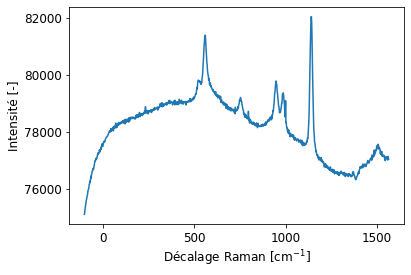

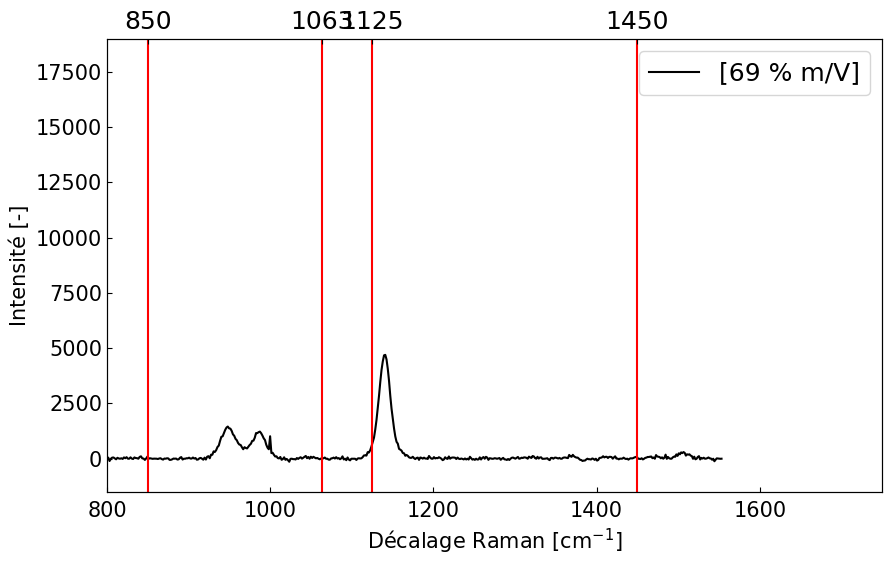

'vodka_05 = Samples("fichier_trait\\Vodka1_100s.TXT", "Vodka à 5%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=70, max_p=50, pente=True, graph=False)\nvodka_10 = Samples("fichier_trait\\Vodka2_100s.TXT", "Vodka à 10%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=100, max_p=50, pente=True, graph=False)\nvodka_20 = Samples("fichier_trait\\Vodka3_100s.TXT", "Vodka à 20%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=100, max_p=50, pente=True, graph=False)\nSamples.analyse()'

In [38]:
eau = Calibration("Raman_GG\\12-04-2023\\Etalons\\Eau.TXT", "Eau", coupe = [280, -1], conc=0, pente=True, zero=True)
ethanol_30 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_30.TXT", "Éthanol à 30%", conc=30, domaine_pic = [500, 600], coupe = [5, -300], divismin = 2, max_c=400, max_p=600, pente=True, graph=False, rawdog=True)
#ethanol_40 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_40.TXT", "Éthanol à 40%", conc=40, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
#ethanol_50 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_50.TXT", "Éthanol à 50%", conc=50, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
#ethanol_60 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_60.TXT", "Éthanol à 60%", conc=60, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
#ethanol_70 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_70.TXT", "Éthanol à 70%", conc=70, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
#ethanol_80 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_80.TXT", "Éthanol à 80%", conc=80, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
#ethanol_100 = Calibration("Raman_GG\\12-04-2023\\Etalons\\Ethanol_100.TXT", "Éthanol à 100%", conc=100, domaine_pic = [880, 900], coupe = [283, -1], divismin = 2, max_c=400, max_p=600, pente=True, graph=False)
Calibration.graphique_combine_ethanolage()

"""vodka_05 = Samples("fichier_trait\\Vodka1_100s.TXT", "Vodka à 5%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=70, max_p=50, pente=True, graph=False)
vodka_10 = Samples("fichier_trait\\Vodka2_100s.TXT", "Vodka à 10%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=100, max_p=50, pente=True, graph=False)
vodka_20 = Samples("fichier_trait\\Vodka3_100s.TXT", "Vodka à 20%", d=5, domaine_pic = [880, 900], coupe = [280, -1], max_c=100, max_p=50, pente=True, graph=False)
Samples.analyse()"""